In [425]:
import math
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import logit, probit, ols

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, confusion_matrix

In [368]:
# Load Data
data = pd.read_excel('./Uber_Data.xlsx', sheet_name=2)

# EXPLORATORY ANALYSIS / DATA CLEANING

In [369]:
data.head()

,city_id,period_start,wait_time,treat,commute,trips_pool,trips_express,rider_cancellations,total_driver_payout,total_matches,total_double_matches
0,Boston,2018-02-19 07:00:00,2 mins,False,True,1415,3245,256,34458.411634,3372,1476
1,Boston,2018-02-19 09:40:00,5 mins,True,False,1461,2363,203,29764.349821,2288,1275
2,Boston,2018-02-19 12:20:00,2 mins,False,False,1362,2184,118,27437.367363,2283,962
3,Boston,2018-02-19 15:00:00,5 mins,True,True,1984,3584,355,44995.452993,4035,2021
4,Boston,2018-02-19 17:40:00,2 mins,False,False,1371,2580,181,27583.955295,2200,979


In [370]:
data.columns

Index(['city_id', 'period_start', 'wait_time', 'treat', 'commute',
       'trips_pool', 'trips_express', 'rider_cancellations',
       'total_driver_payout', 'total_matches', 'total_double_matches'],
      dtype='object')

In [371]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   city_id               126 non-null    object        
 1   period_start          126 non-null    datetime64[ns]
 2   wait_time             126 non-null    object        
 3   treat                 126 non-null    bool          
 4   commute               126 non-null    bool          
 5   trips_pool            126 non-null    int64         
 6   trips_express         126 non-null    int64         
 7   rider_cancellations   126 non-null    int64         
 8   total_driver_payout   126 non-null    float64       
 9   total_matches         126 non-null    int64         
 10  total_double_matches  126 non-null    int64         
dtypes: bool(2), datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 9.2+ KB


In [372]:
data.select_dtypes(include = 'object').nunique()

# All data is from Boston
# Wait times can be of 2 mins or 5 mins

city_id      1
wait_time    2
dtype: int64

In [373]:
# Descriptive statistics measures for the entire dataset
sumstats=data.describe()
sumstats.round(decimals=2)

,trips_pool,trips_express,rider_cancellations,total_driver_payout,total_matches,total_double_matches
count,126.00,126.00,126.00,126.00,126.00,126.00
mean,1408.01,2515.52,177.74,28237.22,2535.75,1322.44
std,257.93,497.69,51.63,5450.95,607.57,350.32
min,771.00,1638.00,95.00,18769.99,1588.00,728.00
25%,1248.25,2225.00,147.75,24721.89,2171.75,1059.75
50%,1397.00,2427.50,166.00,27352.84,2361.00,1282.50
75%,1580.25,2661.75,187.25,30586.11,2714.50,1481.75
max,2241.00,4507.00,355.00,48600.42,5005.00,2739.00


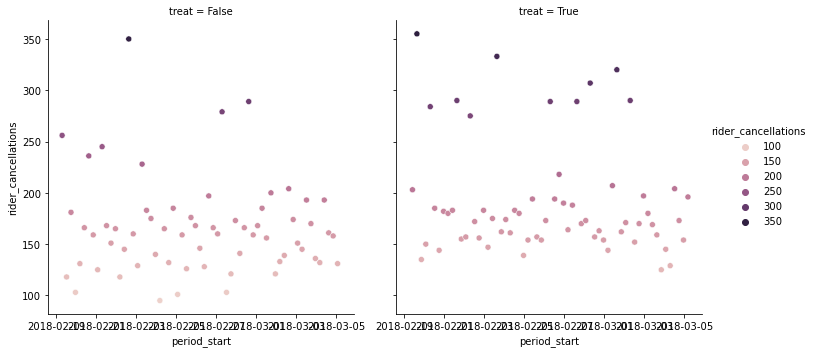

In [473]:
fig1 = sns.relplot(data=data, x="period_start", y="rider_cancellations", col="treat", hue="rider_cancellations",
            kind="scatter")
fig1.figure.savefig("output.png")
# fig1.savefig('test.png')

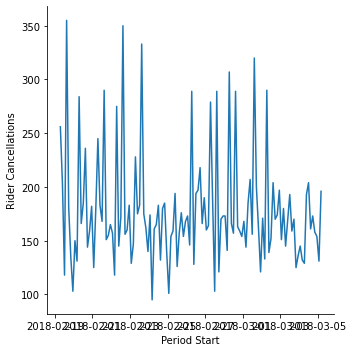

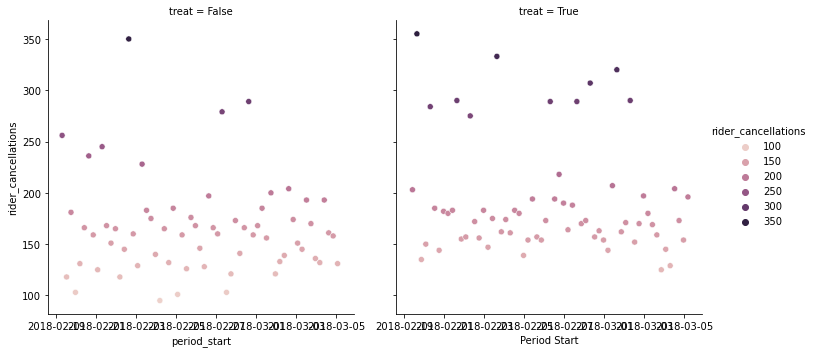

In [487]:
# 1
fig1 = sns.relplot(x="period_start", y="rider_cancellations", kind="line", ci="sd", data=data)
plt.xlabel('Period Start')
plt.ylabel('Rider Cancellations')
print(fig1)
plt.savefig('fig1.png', dpi = 300)

# 2
fig2 = sns.relplot(data=data, x="period_start", y="rider_cancellations", col="treat", hue="rider_cancellations",
            kind="scatter")
plt.xlabel('Period Start')
plt.ylabel('Rider Cancellations')
print(fig2)
plt.savefig('fig2.png', dpi = 300)

## Check weekends? Maybe cancellations are higher on the weekends.
## Then check correlation with total_matches

### Creation of new weekend variable

AxesSubplot(0.125,0.125;0.775x0.755)


0      0
1      0
2      0
3      0
4      0
      ..
121    1
122    1
123    1
124    0
125    0
Name: weekend, Length: 126, dtype: int64

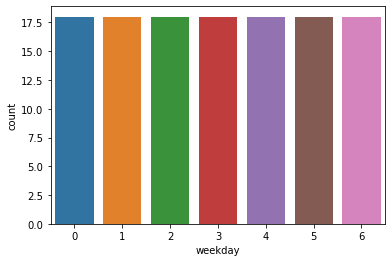

In [375]:
#### Explore weekend or not weekend variable and look for changes
# Create new variable to represent the day of the week
data['weekday'] = data['period_start'].dt.dayofweek

# Create weekend (1) or not weekend (0) binary variable
def id_weekend(row):
    if row in (5,6):
        return 1 # weekend day -- Saturday or Sunday
    else:
        return 0 # not weekend day
data['weekend'] = data['weekday'].apply(lambda row: id_weekend(row))

# Check distribution of new categorical variables
print(sns.countplot(data = data, x = 'weekday'))

## data is equally spread between the days of the week

# Drop 'weekday' column
data = data.drop(columns = {'weekday'})

data['weekend']

<AxesSubplot:xlabel='weekend', ylabel='count'>

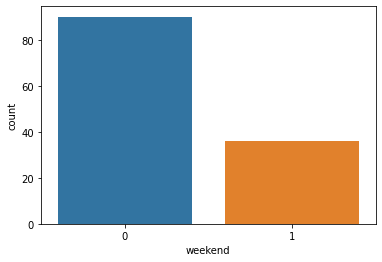

In [376]:
# Check distribution of new categorical variables
sns.countplot(data = data, x = 'weekend')

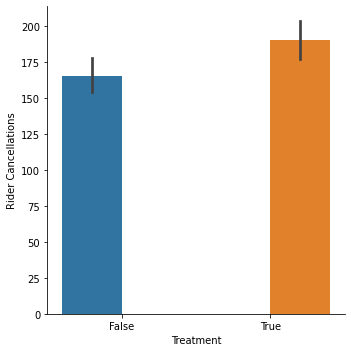

In [488]:
# Rider cancellations by treatment --> treatment group (5 minute wait times) seem to have more cancellations
# 3
fig3 = sns.catplot(x="treat", y="rider_cancellations", hue="treat", kind="bar", data=data)
plt.xlabel('Treatment')
plt.ylabel('Rider Cancellations')
print(fig3)
plt.savefig('fig3.png', dpi = 300)

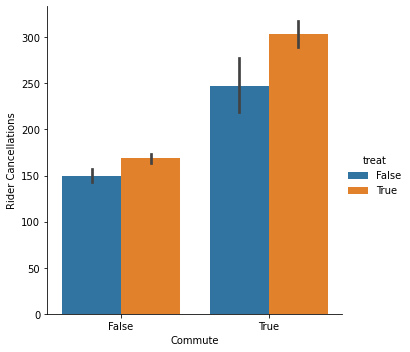

In [489]:
# In both groups, rush hours seem to have more rider cancellations
# 4
fig4 = sns.catplot(x="commute", y="rider_cancellations", hue="treat", kind="bar", data=data)
plt.xlabel('Commute')
plt.ylabel('Rider Cancellations')
print(fig4)
plt.savefig('fig4.png', dpi = 300)

In [377]:
#divide the data into 2 dataframes: one for the treatment group and one for the control group. Use the "treatment" variable as the decision rule to divide the data set
df_treatment = data[data['treat']]
df_control = data[data['treat'] == False]

In [378]:
#check to the dataframe to make sure that only the treatment group is in the treatment dataframe
df_treatment

,city_id,period_start,wait_time,treat,commute,trips_pool,trips_express,rider_cancellations,total_driver_payout,total_matches,total_double_matches,weekend
1,Boston,2018-02-19 09:40:00,5 mins,True,False,1461,2363,203,29764.349821,2288,1275,0
3,Boston,2018-02-19 15:00:00,5 mins,True,True,1984,3584,355,44995.452993,4035,2021,0
5,Boston,2018-02-19 20:20:00,5 mins,True,False,1401,2022,135,23888.110848,2066,1062,0
7,Boston,2018-02-20 01:40:00,5 mins,True,False,1691,2018,150,25794.869920,1918,1281,0
9,Boston,2018-02-20 07:00:00,5 mins,True,True,1815,2539,284,34047.473898,2624,1565,0
...,...,...,...,...,...,...,...,...,...,...,...,...
117,Boston,2018-03-04 07:00:00,5 mins,True,False,1515,2059,129,22995.159002,1828,1063,1
119,Boston,2018-03-04 12:20:00,5 mins,True,False,1818,1970,204,24339.583561,1974,1510,1
121,Boston,2018-03-04 17:40:00,5 mins,True,False,1718,2655,173,28288.521151,2600,1361,1
123,Boston,2018-03-04 23:00:00,5 mins,True,False,1157,2359,154,23525.115952,2323,1473,1


In [455]:
# Descriptive statistics table for treatment group
sumstats_treat = df_treatment.describe()
sumstats_treat.round(decimals=2)

,trips_pool,trips_express,rider_cancellations,total_driver_payout,total_matches,total_double_matches,weekend
count,63.00,63.00,63.00,63.00,63.00,63.00,63.00
mean,1460.70,2419.38,190.13,27183.20,2438.30,1357.73,0.29
std,271.16,462.19,53.83,5043.15,576.11,324.71,0.46
min,829.00,1638.00,125.00,18769.99,1588.00,728.00,0.00
25%,1298.00,2085.50,156.50,23937.15,2105.00,1137.00,0.00
50%,1435.00,2361.00,173.00,26017.53,2299.00,1322.00,0.00
75%,1632.50,2536.50,195.00,28995.23,2552.50,1485.00,1.00
max,2241.00,3946.00,355.00,44995.45,4203.00,2739.00,1.00


In [456]:
# Descriptive statistics table for control group
sumstats_control = df_control.describe()
sumstats_control.round(decimals=2)

,trips_pool,trips_express,rider_cancellations,total_driver_payout,total_matches,total_double_matches,weekend
count,63.00,63.00,63.00,63.00,63.00,63.00,63.00
mean,1355.32,2611.67,165.35,29291.24,2633.21,1287.16,0.29
std,234.44,516.71,46.54,5675.73,626.93,373.45,0.46
min,771.00,1845.00,95.00,22153.19,1885.00,735.00,0.00
25%,1201.50,2264.50,132.50,25105.86,2206.50,1026.50,0.00
50%,1362.00,2496.00,160.00,28041.73,2541.00,1211.00,0.00
75%,1486.00,2757.50,178.50,31438.04,2737.50,1478.00,1.00
max,1957.00,4507.00,350.00,48600.42,5005.00,2533.00,1.00


In [379]:
def check_mannwhitney(var):
    u_statistic, p_value = stats.mannwhitneyu(df_treatment[var], df_control[var])
    print(f'U-Statistic ({var}): ', u_statistic)
    print(f'p-value: ({var})', p_value)
    if p_value <= 0.05:
        print('We can reject the null hypothesis. The variable significantly differs by treatment.')
    else:
        print('We cannot reject the null hypothesis. The variable does not significantly differ by treatment.')
    print('')

In [380]:
#conduct a mann-whitney test to test whether a variable, in this example rider_cancellations, differs by treatment.
#is the number of rider_cancellations statistically significantly different in the treatment group than the control group?

print('Using an alpha of 0.05: \n')
for var_name in df_treatment:
    if var_name not in ('city_id', 'period_start', 'wait_time', 'treat'):
        print(f'Is the {var_name} variable statistically significantly different in the treatment group than the control group?')
        check_mannwhitney(var_name)

Using an alpha of 0.05: 

Is the commute variable statistically significantly different in the treatment group than the control group?
U-Statistic (commute):  1984.5
p-value: (commute) 1.0
We cannot reject the null hypothesis. The variable does not significantly differ by treatment.

Is the trips_pool variable statistically significantly different in the treatment group than the control group?
U-Statistic (trips_pool):  2477.5
p-value: (trips_pool) 0.01625941824302551
We can reject the null hypothesis. The variable significantly differs by treatment.

Is the trips_express variable statistically significantly different in the treatment group than the control group?
U-Statistic (trips_express):  1477.5
p-value: (trips_express) 0.013460836315667414
We can reject the null hypothesis. The variable significantly differs by treatment.

Is the rider_cancellations variable statistically significantly different in the treatment group than the control group?
U-Statistic (rider_cancellations):  26

#### Variables which differ between groups:
 - trips_pool
 - trips_express
 - rider_cancellations
 - total_driver_payout
 - total_matches

### Explore dubious relationships to find potential multicollinearity issues
##### Plot ind variables against each other to check for multicollinearity (and correlation matrix)
##### - remove one from every highly correlated pair

<AxesSubplot:xlabel='total_matches', ylabel='total_driver_payout'>

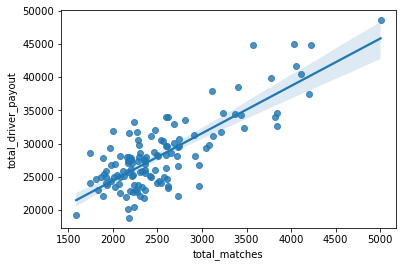

In [381]:
# total_matches and total_driver_payout
sns.regplot(x='total_matches', y='total_driver_payout', data=data)

## Positively correlated --> REMOVE one of the variables

<AxesSubplot:xlabel='total_matches', ylabel='commute'>

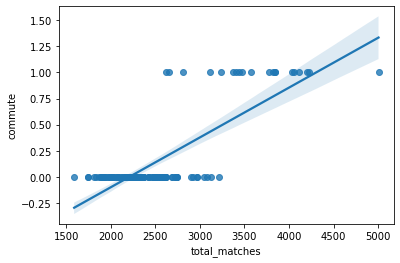

In [382]:
# commute and total_matches
sns.regplot(x='total_matches', y='commute', data=data)

## Potentially correlated. Commute hours tend to have more matches --> REMOVE one of the variables 

<AxesSubplot:xlabel='trips_pool', ylabel='trips_express'>

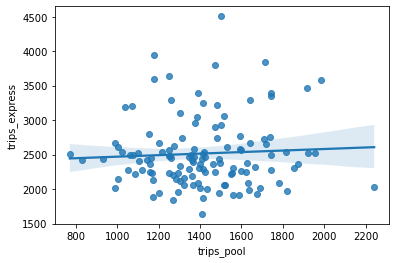

In [309]:
# trips_pool and trips_express
sns.regplot(x='trips_pool', y='trips_express', data=data)

## Don't seem to be correlated

In [476]:
# Correlation matrix of numerical data
data.select_dtypes(exclude = 'object').corr().style.background_gradient(cmap = 'coolwarm')

,treat,commute,trips_pool,trips_express,rider_cancellations,total_driver_payout,total_matches,total_double_matches,weekend
treat,1.000000,-0.000000,0.205098,-0.193948,0.240905,-0.194136,-0.161037,0.101125,-0.000000
commute,-0.000000,1.000000,0.204911,0.736340,0.821942,0.751820,0.786761,0.595798,-0.274721
trips_pool,0.205098,0.204911,1.000000,0.057703,0.372003,0.449967,0.085050,0.134487,-0.168861
trips_express,-0.193948,0.736340,0.057703,1.000000,0.717460,0.795741,0.961497,0.757889,-0.082074
rider_cancellations,0.240905,0.821942,0.372003,0.717460,1.000000,0.724286,0.743148,0.667225,-0.245477
total_driver_payout,-0.194136,0.751820,0.449967,0.795741,0.724286,1.000000,0.796383,0.639006,-0.171553
total_matches,-0.161037,0.786761,0.085050,0.961497,0.743148,0.796383,1.000000,0.734833,-0.109770
total_double_matches,0.101125,0.595798,0.134487,0.757889,0.667225,0.639006,0.734833,1.000000,-0.047026
weekend,-0.000000,-0.274721,-0.168861,-0.082074,-0.245477,-0.171553,-0.109770,-0.047026,1.000000


#### Conclusions (variables to remove > 0.7 correlation)
 - commute OR trips_express
 - commute OR total_driver_payout
 - commute OR total_matches
 - trips_express OR total_driver_payout
 - trips_express OR total_matches
 - trips_express OR total_double_matches
 - total_driver_payout OR total_matches
 - total_matches OR total_double_matches

### Relationship between independent variables and the dependent variable

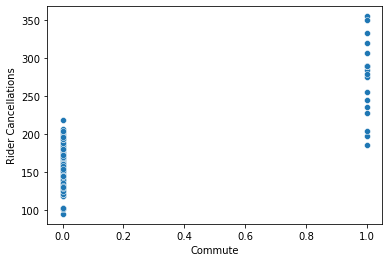

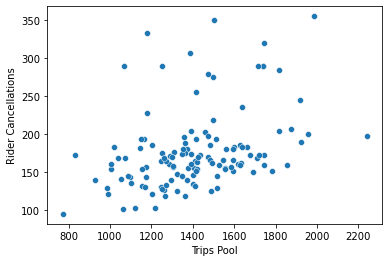

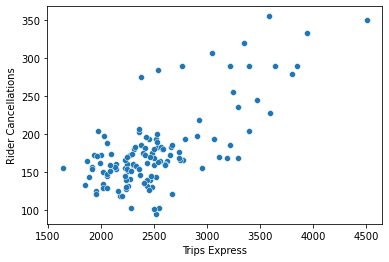

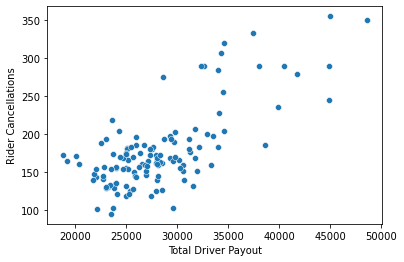

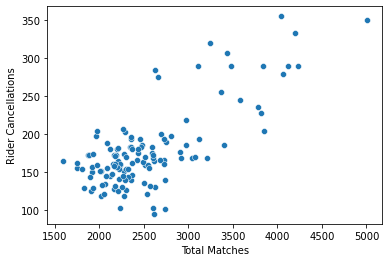

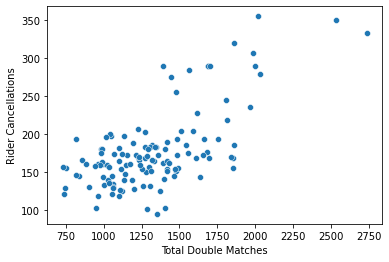

In [500]:
# Generate scatter plots for each numerical variable against the dependent/target variable
# 5 - 10
fignum = 5
for col in data.columns:
    if col in ('commute','trips_pool', 'trips_express', 'total_driver_payout', 'total_matches', 'total_double_matches'):
        fig = sns.scatterplot(data = data, x = col, y = 'rider_cancellations')
        col = col.replace("_", " ").title()
        plt.xlabel(col)
        plt.ylabel('Rider Cancellations')
        plt.savefig(f'fig{fignum}.png', dpi = 300)
        plt.show()
        fignum += 1

#### Relationships between each independent variable and the dependent variable based on scatter plots

 - commute -> positive correlation
 - trips_pool -> weak positive correlation
 - trips_express -> positive correlation
 - total_driver_payout -> positive correlation
 - total_matches -> positive correlation
 - total_double_matches -> positive correlation

## FIT MODEL - statsmodels

In [385]:
model1 = ols("rider_cancellations ~ treat + trips_pool + total_matches + weekend", data).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     rider_cancellations   R-squared:                       0.756
Model:                             OLS   Adj. R-squared:                  0.748
Method:                  Least Squares   F-statistic:                     93.55
Date:                 Fri, 20 May 2022   Prob (F-statistic):           4.39e-36
Time:                         08:23:28   Log-Likelihood:                -586.47
No. Observations:                  126   AIC:                             1183.
Df Residuals:                      121   BIC:                             1197.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -61.0301     16.194     -3.769      0.000     -93.090     -28.970
treat[T.True]    32.7384      4.804      6.815      0.000      23.227      42.250
trips_pool        0.0442      0.009      4.713      0.000       0.026       0.063
total_matches     0.0648      0.004     16.539      0.000       0.057       0.073
weekend         -14.1772      5.216     -2.718      0.008     -24.503      -3.852
==============================================================================
Omnibus:                        3.125   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.210   Jarque-Bera (JB):                2.929
Skew:                           0.373   Prob(JB):                        0.231
Kurtosis:                       2.979   Cond. No.                     2.08e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### EVALUATE MODEL

 - Adjusted R-Squared -> 74.8%
     - this model explains 74.8% of the variance in the rider_cancellations variable
 - P-value -> below 0.05 for all variables used
     - all variables used are statistically significant using a significance level of 5%

#### Residual plot of errors (y), ind variable (x) - zero mean of errors and autocorrelation of errors -- should average to 0

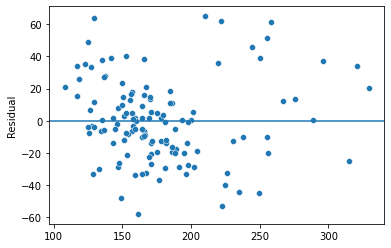

In [501]:
# Residual plot for model1
# 11
fig11 = sns.scatterplot(x = model1.fittedvalues, y = model1.resid)
plt.ylabel('Residual')
plt.axhline(0)
plt.savefig('fig11.png', dpi = 300)

## The residuals seems to average to around 0, showing this does not represent a problem in model1

Figure(864x576)


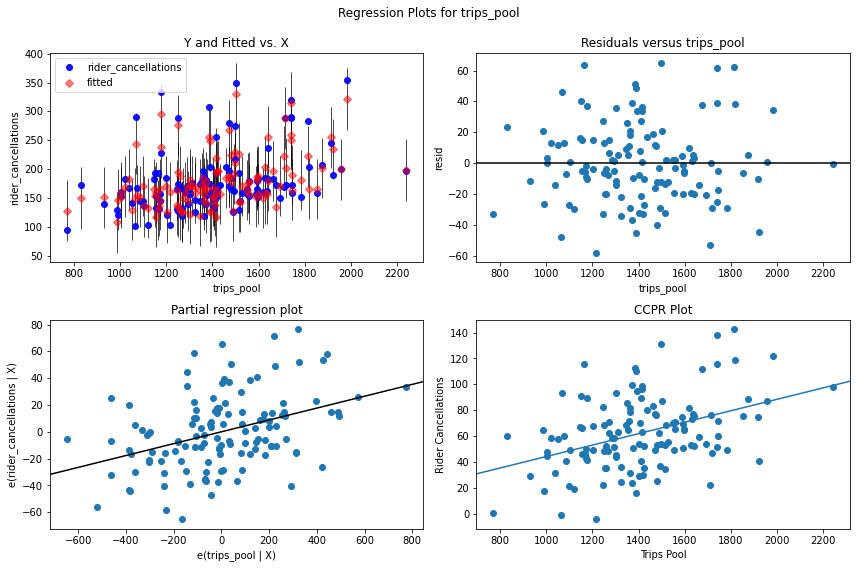

In [503]:
#define figure size
fig = plt.figure(figsize=(12,8))

#produce regression plots
# 12
fig12 = sm.graphics.plot_regress_exog(model1, 'trips_pool', fig=fig)
plt.xlabel('Trips Pool')
plt.ylabel('Rider Cancellations')
print(fig12)
plt.savefig('fig12.png', dpi = 300)

Figure(864x576)


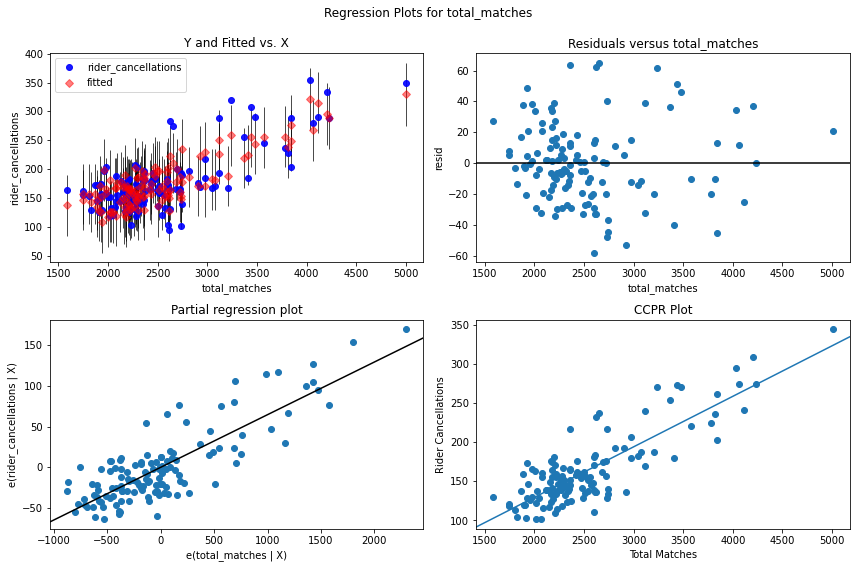

In [504]:
#define figure size
fig2 = plt.figure(figsize=(12,8))

#produce regression plots
# 13
fig13 = sm.graphics.plot_regress_exog(model1, 'total_matches', fig=fig2)
plt.xlabel('Total Matches')
plt.ylabel('Rider Cancellations')
print(fig13)
plt.savefig('fig13.png', dpi = 300)

## TREATMENT GROUP (5 MINUTES)

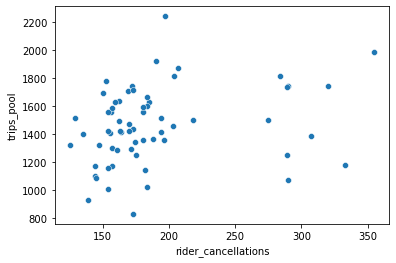

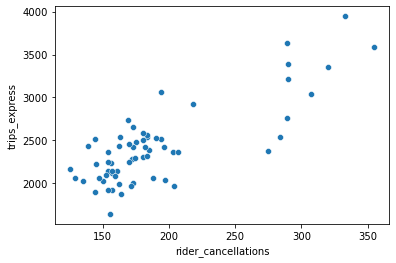

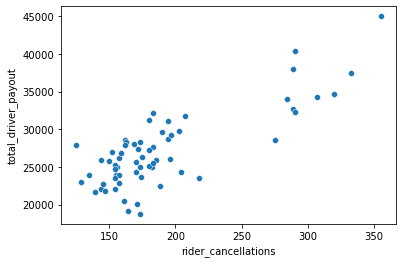

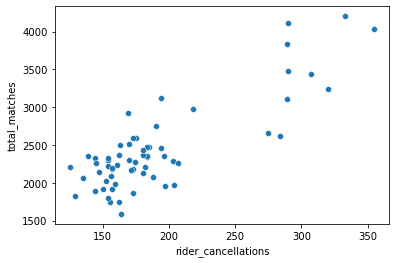

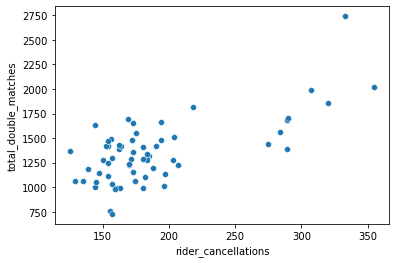

In [400]:
# Generate scatter plots for each numerical variable in the 5 minute dataframe against the dependent variable
for col in df_treatment.columns:
    if col in ('trips_pool', 'trips_express', 'total_driver_payout', 'total_matches', 'total_double_matches'):
        sns.scatterplot(data = df_treatment, x = 'rider_cancellations', y = col)
        plt.show()

#### Relationships between each independent variable and the dependent variable based on scatter plots

 - trips_pool ->  non-linear relationship (REMOVE)
 - trips_express -> linear relationship
 - total_driver_payout -> linear relationship
 - total_matches -> linear relationship
 - total_double_matches -> linear relationship

### Check for Multicollinearity

In [398]:
# Correlation matrix of numerical data
df_treatment.select_dtypes(exclude = 'object').corr().style.background_gradient(cmap = 'coolwarm')

,treat,commute,trips_pool,trips_express,rider_cancellations,total_driver_payout,total_matches,total_double_matches,weekend
treat,nan,nan,nan,nan,nan,nan,nan,nan,nan
commute,nan,1.000000,0.127894,0.724559,0.919836,0.743293,0.787465,0.606904,-0.274721
trips_pool,nan,0.127894,1.000000,0.026416,0.251743,0.467349,0.058743,0.084748,-0.091509
trips_express,nan,0.724559,0.026416,1.000000,0.804068,0.754115,0.961547,0.764661,-0.109420
rider_cancellations,nan,0.919836,0.251743,0.804068,1.000000,0.805774,0.836210,0.685877,-0.321307
total_driver_payout,nan,0.743293,0.467349,0.754115,0.805774,1.000000,0.779575,0.584984,-0.180031
total_matches,nan,0.787465,0.058743,0.961547,0.836210,0.779575,1.000000,0.729242,-0.128210
total_double_matches,nan,0.606904,0.084748,0.764661,0.685877,0.584984,0.729242,1.000000,-0.144216
weekend,nan,-0.274721,-0.091509,-0.109420,-0.321307,-0.180031,-0.128210,-0.144216,1.000000


#### Conclusions (variables to remove > 0.7 correlation)
 - commute OR trips_express
 - commute OR total_driver_payout
 - commute OR total_matches
 - trips_express OR total_driver_payout
 - trips_express OR total_matches
 - trips_express OR total_double_matches
 - total_driver_payout OR total_matches
 - total_matches OR total_double_matches

## FIT MODEL - statsmodels

In [401]:
model2_treat = ols("rider_cancellations ~  total_matches + weekend", df_treatment).fit() # 5 mins
model2_treat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     rider_cancellations   R-squared:                       0.746
Model:                             OLS   Adj. R-squared:                  0.737
Method:                  Least Squares   F-statistic:                     88.04
Date:                 Fri, 20 May 2022   Prob (F-statistic):           1.42e-18
Time:                         08:49:58   Log-Likelihood:                -296.84
No. Observations:                   63   AIC:                             599.7
Df Residuals:                       60   BIC:                             606.1
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        13.3415     15.779      0.846      0.401     -18.221      44.904
total_matches     0.0755      0.006     12.317      0.000       0.063       0.088
weekend         -25.7287      7.757     -3.317      0.002     -41.244     -10.213
==============================================================================
Omnibus:                        6.044   Durbin-Watson:                   2.263
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                5.482
Skew:                           0.715   Prob(JB):                       0.0645
Kurtosis:                       3.203   Cond. No.                     1.15e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### EVALUATE MODEL

 - Adjusted R-Squared -> 73.7%
     - this model explains 73.7% of the variance in the rider_cancellations variable
 - P-value -> below 0.05 for both variables used
     - both variables used are statistically significant using a significance level of 5%

#### Residual plot of errors (y), ind variable (x) - zero mean of errors and autocorrelation of errors -- should average to 0

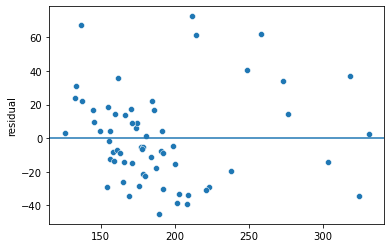

In [409]:
# Residual plot for model1
sns.scatterplot(x = model2_treat.fittedvalues, y = model2_treat.resid)
plt.ylabel('residual')
plt.axhline(0)

## The residuals seems to average to around 0, showing this does not represent a problem in model2_treat

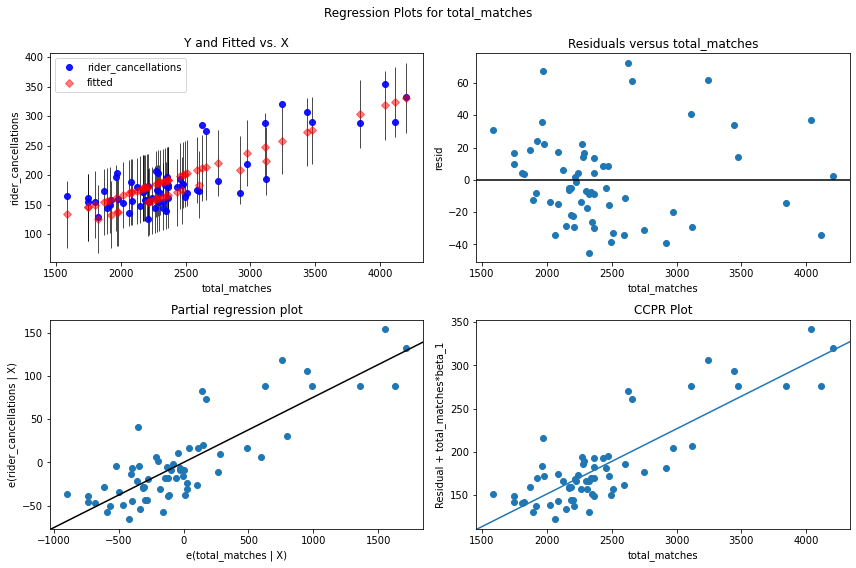

In [410]:
#define figure size
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(model2_treat, 'total_matches', fig=fig)

## CONTROL GROUP (2 MINUTES)

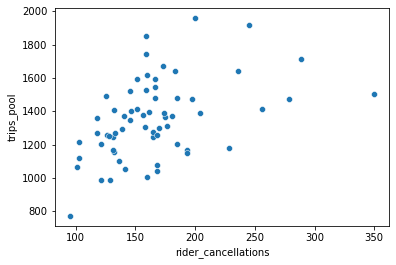

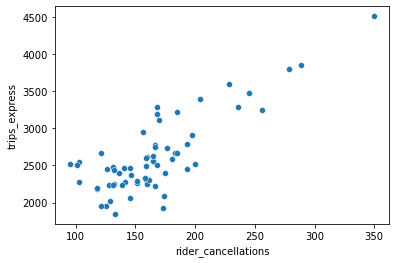

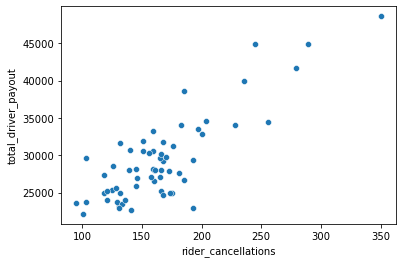

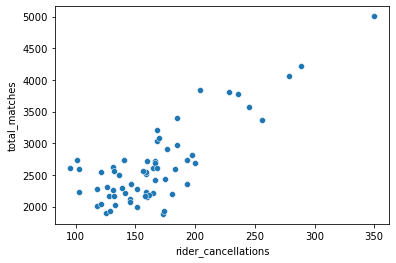

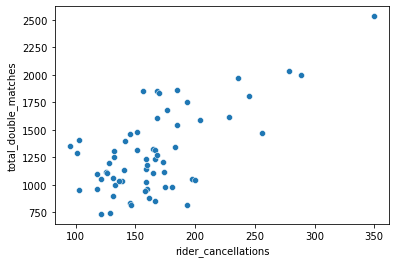

In [399]:
# Generate scatter plots for each numerical variable in the 5 minute dataframe against the dependent variable
for col in df_control.columns:
    if col in ('trips_pool', 'trips_express', 'total_driver_payout', 'total_matches', 'total_double_matches'):
        sns.scatterplot(data = df_control, x = 'rider_cancellations', y = col)
        plt.show()

#### Relationships between each independent variable and the dependent variable based on scatter plots

 - trips_pool -> weak linear relationship
 - trips_express -> linear relationship
 - total_driver_payout -> linear relationship
 - total_matches -> linear relationship
 - total_double_matches -> linear relationship

### Check for Multicollinearity

In [404]:
# Correlation matrix of numerical data
df_control.select_dtypes(exclude = 'object').corr().style.background_gradient(cmap = 'coolwarm')

,treat,commute,trips_pool,trips_express,rider_cancellations,total_driver_payout,total_matches,total_double_matches,weekend
treat,nan,nan,nan,nan,nan,nan,nan,nan,nan
commute,nan,1.000000,0.304780,0.776082,0.767315,0.789452,0.807443,0.594606,-0.274721
trips_pool,nan,0.304780,1.000000,0.180944,0.457141,0.563094,0.191395,0.151455,-0.267218
trips_express,nan,0.776082,0.180944,1.000000,0.814604,0.814489,0.960362,0.821643,-0.060869
rider_cancellations,nan,0.767315,0.457141,0.814604,1.000000,0.828348,0.806330,0.659194,-0.175270
total_driver_payout,nan,0.789452,0.563094,0.814489,0.828348,1.000000,0.799210,0.744386,-0.170878
total_matches,nan,0.807443,0.191395,0.960362,0.806330,0.799210,1.000000,0.794041,-0.095800
total_double_matches,nan,0.594606,0.151455,0.821643,0.659194,0.744386,0.794041,1.000000,0.036812
weekend,nan,-0.274721,-0.267218,-0.060869,-0.175270,-0.170878,-0.095800,0.036812,1.000000


#### Conclusions (variables to remove > 0.7 correlation)
 - commute OR trips_express
 - commute OR total_driver_payout
 - commute OR total_matches
 - trips_express OR total_driver_payout
 - trips_express OR total_matches
 - trips_express OR total_double_matches
 - total_driver_payout OR total_matches
 - total_driver_payout OR total_double_matches
 - total_matches OR total_double_matches

## FIT MODEL - statsmodels

In [405]:
model3_control = ols("rider_cancellations ~ trips_pool + total_matches + weekend", df_control).fit() # 2 mins
model3_control.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     rider_cancellations   R-squared:                       0.746
Model:                             OLS   Adj. R-squared:                  0.733
Method:                  Least Squares   F-statistic:                     57.69
Date:                 Fri, 20 May 2022   Prob (F-statistic):           1.53e-17
Time:                         08:54:20   Log-Likelihood:                -287.68
No. Observations:                   63   AIC:                             583.4
Df Residuals:                       59   BIC:                             591.9
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -62.7605     21.628     -2.902      0.005    -106.038     -19.483
trips_pool        0.0613      0.014      4.465      0.000       0.034       0.089
total_matches     0.0553      0.005     11.130      0.000       0.045       0.065
weekend          -2.1830      6.969     -0.313      0.755     -16.128      11.762
==============================================================================
Omnibus:                        0.369   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.832   Jarque-Bera (JB):                0.454
Skew:                           0.170   Prob(JB):                        0.797
Kurtosis:                       2.760   Cond. No.                     2.17e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.17e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### EVALUATE MODEL

 - Adjusted R-Squared -> 73.3%
     - this model explains 73.3% of the variance in the rider_cancellations variable
 - P-value -> above 0.05 for the weekend variable
     - the weekend variable is not statistically significant in the control group model
     - all other variables used are statistically significant using a significance level of 5%

#### Residual plot of errors (y), ind variable (x) - zero mean of errors and autocorrelation of errors -- should average to 0

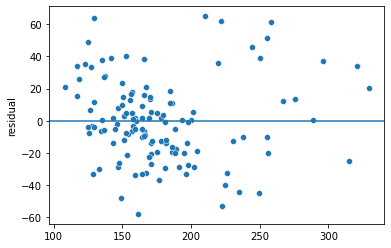

In [386]:
# Residual plot for model1
sns.scatterplot(x = model1.fittedvalues, y = model1.resid)
plt.ylabel('residual')
plt.axhline(0)

## The residuals seems to average to around 0, showing this does not represent a problem in model1

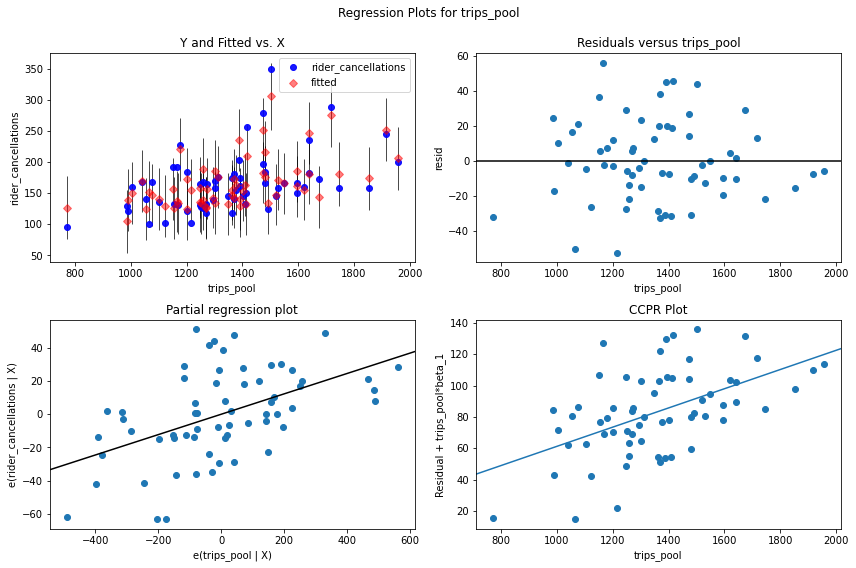

In [411]:
#define figure size
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(model3_control, 'trips_pool', fig=fig)

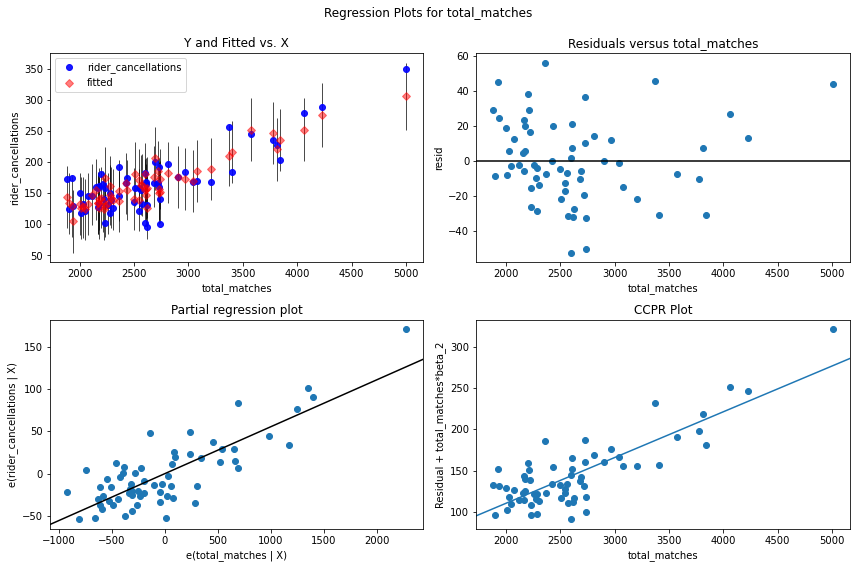

In [412]:
#define figure size
fig2 = plt.figure(figsize=(12,8))

#produce regression plots
fig2 = sm.graphics.plot_regress_exog(model3_control, 'total_matches', fig=fig2)

# FIT MODELS - scikit-learn

## Fit Original Data Regression Model - 5 minutes wait time

In [451]:
# Train / Test Split
X = data[['trips_pool', 'total_matches', 'weekend']]
y = data['rider_cancellations']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [452]:
# Fit training data
LReg = LinearRegression()
LReg.fit(X_train, y_train)

LinearRegression()

In [453]:
# Predict test set results
y_pred = LReg.predict(X_test)

In [454]:
# Calculate RMSE to compare models
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE (root mean squared error) of the model: ', np.round(rmse, 4))

# Lower RMSE value = better fit

RMSE (root mean squared error) of the model:  27.6784


## Fit Treatment Group Regression Model - 5 minutes wait time

In [421]:
# Train / Test Split
X_treatment = df_treatment[['total_matches', 'weekend']]
y_treatment = df_treatment['rider_cancellations']
X_train_treatment, X_test_treatment, y_train_treatment, y_test_treatment = train_test_split(X_treatment, y_treatment, test_size = 0.3, random_state = 42)

In [422]:
# Fit training data
LReg_treatment = LinearRegression()
LReg_treatment.fit(X_train_treatment, y_train_treatment)

LinearRegression()

In [427]:
# Predict test set results
y_pred_treatment = LReg_treatment.predict(X_test_treatment)

In [440]:
# Calculate RMSE to compare models
rmse = math.sqrt(mean_squared_error(y_test_treatment, y_pred_treatment))
print('RMSE (root mean squared error) of the treatment group model: ', np.round(rmse, 4))

# Lower RMSE value = better fit

RMSE (root mean squared error) of the treatment group model:  23.5941


## Fit Control Group Regression Model - 2 minutes wait time

In [442]:
# Train / Test Split
X_control = df_control[['trips_pool', 'total_matches', 'weekend']]
y_control = df_control['rider_cancellations']
X_train_control, X_test_control, y_train_control, y_test_control = train_test_split(X_control, y_control, test_size = 0.3, random_state = 42)

In [443]:
# Fit training data
LReg_control = LinearRegression()
LReg_control.fit(X_train_control, y_train_control)

LinearRegression()

In [444]:
# Predict test set results
y_pred_control = LReg_control.predict(X_test_control)

In [445]:
# Calculate RMSE to compare models
rmse = math.sqrt(mean_squared_error(y_test_control, y_pred_control))
print('RMSE (root mean squared error) of the control group model: ', np.round(rmse, 4))

# Lower RMSE value = better fit

RMSE (root mean squared error) of the control group model:  27.9168


## Assignment Instructions: You have been tasked with analyzing whether Uber should extend the Express Pool wait time from 2 minutes to 5 minutes. 
 1. Generate a model which can be used by Uber to predict cancellations. Estimate your model using a regression technique of your choosing. 
 2. Use the Jupyter Notebook template I provided as a jumping off point to help you get started. Your analysis should address the following:
     - Customer experience: what four variables would you use to capture how the customer experience is affected by the increase in wait times?
     - Efficiency metrics: what 3 variables would you use to capture how efficiency is affected by the increase in wait times?
     - Is there a difference in the customer experience metrics and efficiency metrics between the 2- and 5-minute wait time groups? 
     - What other differences exist? Are there differences between commuting hours (rush hours) and non-commuting hours (non-rush hours). If so, how does this affect your recommendations?
     - Provide statistical evidence to back up your conclusions.
 3. Discuss your results. What do your results imply for Uber? What course of action would you recommend for Uber?

 - Bonus points: Generate a calculation that will tell Uber lose from keeping the wait time. 

## NEXT TO DO
 - explore weekend or not weekend variable and look for changes (redo exploratory analysis based on the addition of that variable) -- DONE
 - make sure exploratory analysis in all regressions are done to check for linear regression assumptions and evaluate models -- DONE
 - fit and evaluate models using scikit learn (add RMSE) (so evaluation metrics used are adjusted r-squared and RMSE) -- DONE
 - answer questions above -- DONE
 - write report
      1. Goal of the project and differences between products and treatment vs control (executive summary)
      2. FOR EACH REGRESSION
         - 2a. Exploratory analysis pre-regression - describe any info about data + discuss some linear regression assumptions + addition of new variables
         - 2b. Discuss model results
         - 2c. Exploratory analysis post-regression to check for more linear regression assumptions
      3. Answer questions above
      4. Conclusion / Final thoughts